# REDHEN DATA ANALYSIS

## LIBRARIES

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# DataFrame
import pandas as pd

# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

Using TensorFlow backend.


In [4]:
# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

In [5]:
# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

In [6]:
# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## SETTING 

In [7]:
# DATASET
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# EXPORT
KERAS_MODEL = "model_culture.h5"
WORD2VEC_MODEL = "model_culture.w2v"
TOKENIZER_MODEL = "tokenizer_culture.pkl"
ENCODER_MODEL = "encoder_culture.pkl"

## READING DATASET 

In [8]:
data = pd.read_csv('redhen_preprocessed.csv')
data.head()

,Unnamed: 0,StoryID,Excerpt,CodesApplied_Combined,ACCOUNT,ACCOUNT_Cultural,ACCOUNT_Individual,ACCOUNT_Other,COMMUNITYRECOVERY,EVENT,...,TRAUMA_Societal,VICTIMS,word_count,char_count,Excerpt_pre,Excerpt_tokenized,Excerpt_nonstop,Excerpt_stemmed,Excerpt_lemmatized,Excerpt_clean
0,7992,NI3079,Elliot Rodger Wangs roommate stabbed Wang and ...,EVENT,0,0,0,0,99,1,...,99,0,34,215.0,elliot rodger wangs roommate stabbed wang two ...,"['elliot', 'rodger', 'wangs', 'roommate', 'sta...","['elliot', 'rodger', 'wangs', 'roommate', 'sta...","['elliot', 'rodger', 'wang', 'roommat', 'stab'...","['elliot', 'rodger', 'wangs', 'roommate', 'sta...","['elliot', 'rodger', 'wang', 'roommat', 'stab'..."
1,4686,NI2689,Because the tragedy unfolded at the start of a...,RESOURCES,0,0,0,0,99,0,...,99,0,32,228.0,tragedy unfolded start holiday weekend school ...,"['tragedy', 'unfolded', 'start', 'holiday', 'w...","['tragedy', 'unfolded', 'start', 'holiday', 'w...","['tragedi', 'unfold', 'start', 'holiday', 'wee...","['tragedy', 'unfolded', 'start', 'holiday', 'w...","['tragedi', 'unfold', 'start', 'holiday', 'wee..."
2,6130,NI2400,Gunrelated restraining orders Also passed in r...,"POLICY, POLICY- Guns, POLICY- Mental health",0,0,0,0,99,0,...,99,0,122,734.0,gunrelated restraining orders also passed resp...,"['gunrelated', 'restraining', 'orders', 'also'...","['gunrelated', 'restraining', 'orders', 'also'...","['gunrel', 'restrain', 'order', 'also', 'pass'...","['gunrelated', 'restraining', 'order', 'also',...","['gunrel', 'restrain', 'order', 'also', 'pass'..."
3,5876,NI1393,Linder said she will also remember Weiss for h...,"VICTIMS, GRIEF/LOSS",0,0,0,0,99,0,...,99,1,100,499.0,linder said also remember weiss epic shot pool...,"['linder', 'said', 'also', 'remember', 'weiss'...","['linder', 'said', 'also', 'remember', 'weiss'...","['linder', 'said', 'also', 'rememb', 'weiss', ...","['linder', 'said', 'also', 'remember', 'wei', ...","['linder', 'said', 'also', 'rememb', 'weiss', ..."
4,4126,NI3259,I mean I know how this goes We all do Werent y...,"ACCOUNTABILITY, ACCOUNT- Culture/societal risk...",1,1,0,0,99,0,...,99,0,85,425.0,mean know goes werent sort expecting father on...,"['mean', 'know', 'goes', 'werent', 'sort', 'ex...","['mean', 'know', 'goes', 'werent', 'sort', 'ex...","['mean', 'know', 'goe', 'werent', 'sort', 'exp...","['mean', 'know', 'go', 'werent', 'sort', 'expe...","['mean', 'know', 'goe', 'werent', 'sort', 'exp..."


In [9]:
data.shape

(8131, 62)

In [10]:
from sklearn.utils import shuffle
data = shuffle(data)
data.head()

,Unnamed: 0,StoryID,Excerpt,CodesApplied_Combined,ACCOUNT,ACCOUNT_Cultural,ACCOUNT_Individual,ACCOUNT_Other,COMMUNITYRECOVERY,EVENT,...,TRAUMA_Societal,VICTIMS,word_count,char_count,Excerpt_pre,Excerpt_tokenized,Excerpt_nonstop,Excerpt_stemmed,Excerpt_lemmatized,Excerpt_clean
1373,3843,NI2584,UC Santa Barbara officials presented Katies pa...,MOURNING,0,0,0,0,99,0,...,99,0,17,107.0,uc santa barbara officials presented katies pa...,"['uc', 'santa', 'barbara', 'officials', 'prese...","['uc', 'santa', 'barbara', 'officials', 'prese...","['uc', 'santa', 'barbara', 'offici', 'present'...","['uc', 'santa', 'barbara', 'official', 'presen...","['uc', 'santa', 'barbara', 'offici', 'present'..."
2282,2568,NI3056,I got into an online debate recently with Lin...,"ACCOUNTABILITY, ACCOUNT- Culture/societal risk...",1,1,1,0,99,0,...,99,0,136,851.0,got online debate recently lindsay beyerstein ...,"['got', 'online', 'debate', 'recently', 'linds...","['got', 'online', 'debate', 'recently', 'linds...","['got', 'onlin', 'debat', 'recent', 'lindsay',...","['got', 'online', 'debate', 'recently', 'linds...","['got', 'onlin', 'debat', 'recent', 'lindsay',..."
6644,6677,NI1492,In contrast the magazine Mother Jones did an e...,MISCELLANEOUS,0,0,0,0,99,0,...,99,0,83,551.0,contrast magazine mother jones extensive inves...,"['contrast', 'magazine', 'mother', 'jones', 'e...","['contrast', 'magazine', 'mother', 'jones', 'e...","['contrast', 'magazin', 'mother', 'jone', 'ext...","['contrast', 'magazine', 'mother', 'jones', 'e...","['contrast', 'magazin', 'mother', 'jone', 'ext..."
7926,4645,NI2900,We also learned that on the day of his murdero...,EVENT,0,0,0,0,99,1,...,99,0,53,291.0,also learned day murderous rampage mother read...,"['also', 'learned', 'day', 'murderous', 'rampa...","['also', 'learned', 'day', 'murderous', 'rampa...","['also', 'learn', 'day', 'murder', 'rampag', '...","['also', 'learned', 'day', 'murderous', 'rampa...","['also', 'learn', 'day', 'murder', 'rampag', '..."
1282,7414,NI2749,Certainly the latest murderous rampage carried...,"ACCOUNTABILITY, ACCOUNT- Individual risk facto...",1,1,1,0,99,0,...,99,0,161,1017.0,certainly latest murderous rampage carried you...,"['certainly', 'latest', 'murderous', 'rampage'...","['certainly', 'latest', 'murderous', 'rampage'...","['certainli', 'latest', 'murder', 'rampag', 'c...","['certainly', 'latest', 'murderous', 'rampage'...","['certainli', 'latest', 'murder', 'rampag', 'c..."


In [11]:
cul = data.loc[data['ACCOUNT_Cultural'] == 1]
cul.head()

,Unnamed: 0,StoryID,Excerpt,CodesApplied_Combined,ACCOUNT,ACCOUNT_Cultural,ACCOUNT_Individual,ACCOUNT_Other,COMMUNITYRECOVERY,EVENT,...,TRAUMA_Societal,VICTIMS,word_count,char_count,Excerpt_pre,Excerpt_tokenized,Excerpt_nonstop,Excerpt_stemmed,Excerpt_lemmatized,Excerpt_clean
2282,2568,NI3056,I got into an online debate recently with Lin...,"ACCOUNTABILITY, ACCOUNT- Culture/societal risk...",1,1,1,0,99,0,...,99,0,136,851.0,got online debate recently lindsay beyerstein ...,"['got', 'online', 'debate', 'recently', 'linds...","['got', 'online', 'debate', 'recently', 'linds...","['got', 'onlin', 'debat', 'recent', 'lindsay',...","['got', 'online', 'debate', 'recently', 'linds...","['got', 'onlin', 'debat', 'recent', 'lindsay',..."
1282,7414,NI2749,Certainly the latest murderous rampage carried...,"ACCOUNTABILITY, ACCOUNT- Individual risk facto...",1,1,1,0,99,0,...,99,0,161,1017.0,certainly latest murderous rampage carried you...,"['certainly', 'latest', 'murderous', 'rampage'...","['certainly', 'latest', 'murderous', 'rampage'...","['certainli', 'latest', 'murder', 'rampag', 'c...","['certainly', 'latest', 'murderous', 'rampage'...","['certainli', 'latest', 'murder', 'rampag', 'c..."
691,5654,NI2267,Officers did perform the check in late April b...,"ACCOUNTABILITY, ACCOUNT- Culture/societal risk...",1,1,0,0,99,0,...,99,0,186,1120.0,officers perform check late april found shy po...,"['officers', 'perform', 'check', 'late', 'apri...","['officers', 'perform', 'check', 'late', 'apri...","['offic', 'perform', 'check', 'late', 'april',...","['officer', 'perform', 'check', 'late', 'april...","['offic', 'perform', 'check', 'late', 'april',..."
3510,2864,NI3260,California has some of the strictest gun laws ...,"PERPETRATOR, ACCOUNTABILITY, ACCOUNT- Culture/...",1,1,0,0,99,0,...,99,0,57,375.0,california strictest gun laws country elliot r...,"['california', 'strictest', 'gun', 'laws', 'co...","['california', 'strictest', 'gun', 'laws', 'co...","['california', 'strictest', 'gun', 'law', 'cou...","['california', 'strictest', 'gun', 'law', 'cou...","['california', 'strictest', 'gun', 'law', 'cou..."
6722,2968,NI2024,Once again we are grieving over deaths and dev...,"ACCOUNTABILITY, ACCOUNT- Culture/societal risk...",1,1,0,0,99,0,...,99,0,58,332.0,grieving deaths devastation caused young man s...,"['grieving', 'deaths', 'devastation', 'caused'...","['grieving', 'deaths', 'devastation', 'caused'...","['griev', 'death', 'devast', 'caus', 'young', ...","['grieving', 'death', 'devastation', 'caused',...","['griev', 'death', 'devast', 'caus', 'young', ..."


In [12]:
cul.shape

(1153, 62)

In [13]:
ncul = data.loc[data['ACCOUNT_Cultural'] == 0]
ncul.head()

,Unnamed: 0,StoryID,Excerpt,CodesApplied_Combined,ACCOUNT,ACCOUNT_Cultural,ACCOUNT_Individual,ACCOUNT_Other,COMMUNITYRECOVERY,EVENT,...,TRAUMA_Societal,VICTIMS,word_count,char_count,Excerpt_pre,Excerpt_tokenized,Excerpt_nonstop,Excerpt_stemmed,Excerpt_lemmatized,Excerpt_clean
1373,3843,NI2584,UC Santa Barbara officials presented Katies pa...,MOURNING,0,0,0,0,99,0,...,99,0,17,107.0,uc santa barbara officials presented katies pa...,"['uc', 'santa', 'barbara', 'officials', 'prese...","['uc', 'santa', 'barbara', 'officials', 'prese...","['uc', 'santa', 'barbara', 'offici', 'present'...","['uc', 'santa', 'barbara', 'official', 'presen...","['uc', 'santa', 'barbara', 'offici', 'present'..."
6644,6677,NI1492,In contrast the magazine Mother Jones did an e...,MISCELLANEOUS,0,0,0,0,99,0,...,99,0,83,551.0,contrast magazine mother jones extensive inves...,"['contrast', 'magazine', 'mother', 'jones', 'e...","['contrast', 'magazine', 'mother', 'jones', 'e...","['contrast', 'magazin', 'mother', 'jone', 'ext...","['contrast', 'magazine', 'mother', 'jones', 'e...","['contrast', 'magazin', 'mother', 'jone', 'ext..."
7926,4645,NI2900,We also learned that on the day of his murdero...,EVENT,0,0,0,0,99,1,...,99,0,53,291.0,also learned day murderous rampage mother read...,"['also', 'learned', 'day', 'murderous', 'rampa...","['also', 'learned', 'day', 'murderous', 'rampa...","['also', 'learn', 'day', 'murder', 'rampag', '...","['also', 'learned', 'day', 'murderous', 'rampa...","['also', 'learn', 'day', 'murder', 'rampag', '..."
3232,1510,NI2535,Christopher MichaelsMartinez 22 was one of six...,"TRAUMA, TRAUMA- Physical, EVENT",0,0,0,0,99,1,...,99,0,52,328.0,christopher michaelsmartinez 22 one six victim...,"['christopher', 'michaelsmartinez', '22', 'one...","['christopher', 'michaelsmartinez', '22', 'one...","['christoph', 'michaelsmartinez', '22', 'one',...","['christopher', 'michaelsmartinez', '22', 'one...","['christoph', 'michaelsmartinez', 'one', 'six'..."
5203,4904,NI2268,He starts casually but its a studied casualnes...,"ACCOUNTABILITY, ACCOUNT- Individual risk facto...",1,0,1,0,99,0,...,99,0,80,469.0,starts casually studied casualness hes trying ...,"['starts', 'casually', 'studied', 'casualness'...","['starts', 'casually', 'studied', 'casualness'...","['start', 'casual', 'studi', 'casual', 'he', '...","['start', 'casually', 'studied', 'casualness',...","['start', 'casual', 'studi', 'casual', 'he', '..."


In [14]:
ncul.shape

(6978, 62)

In [15]:
ncul = ncul.sample(1153)
ncul.head()

,Unnamed: 0,StoryID,Excerpt,CodesApplied_Combined,ACCOUNT,ACCOUNT_Cultural,ACCOUNT_Individual,ACCOUNT_Other,COMMUNITYRECOVERY,EVENT,...,TRAUMA_Societal,VICTIMS,word_count,char_count,Excerpt_pre,Excerpt_tokenized,Excerpt_nonstop,Excerpt_stemmed,Excerpt_lemmatized,Excerpt_clean
3442,2737,NI3122,Richard Martinez whose son Christopher Michael...,"POLICY, POLICY- Guns",0,0,0,0,99,0,...,99,0,20,136.0,richard martinez whose son christopher michael...,"['richard', 'martinez', 'whose', 'son', 'chris...","['richard', 'martinez', 'whose', 'son', 'chris...","['richard', 'martinez', 'whose', 'son', 'chris...","['richard', 'martinez', 'whose', 'son', 'chris...","['richard', 'martinez', 'whose', 'son', 'chris..."
1842,5237,NI2972,A 22yearold student last Friday killed six peo...,EVENT,0,0,0,0,99,1,...,99,0,21,120.0,22yearold student last friday killed six peopl...,"['22yearold', 'student', 'last', 'friday', 'ki...","['22yearold', 'student', 'last', 'friday', 'ki...","['22yearold', 'student', 'last', 'friday', 'ki...","['22yearold', 'student', 'last', 'friday', 'ki...","['yearold', 'student', 'last', 'friday', 'kill..."
6433,4555,NI1194,Killers parents Peter and Lichin Rodger Daily ...,PHOTO,0,0,0,0,99,0,...,99,0,47,312.0,killers parents peter lichin rodger daily news...,"['killers', 'parents', 'peter', 'lichin', 'rod...","['killers', 'parents', 'peter', 'lichin', 'rod...","['killer', 'parent', 'peter', 'lichin', 'rodge...","['killer', 'parent', 'peter', 'lichin', 'rodge...","['killer', 'parent', 'peter', 'lichin', 'rodge..."
2056,4928,NI2695,As authorities reconstructed the events they w...,"INVESTIGATION, TRAUMA, TRAUMA- Physical",0,0,0,0,99,0,...,99,0,43,276.0,authorities reconstructed events would conclud...,"['authorities', 'reconstructed', 'events', 'wo...","['authorities', 'reconstructed', 'events', 'wo...","['author', 'reconstruct', 'event', 'would', 'c...","['authority', 'reconstructed', 'event', 'would...","['author', 'reconstruct', 'event', 'would', 'c..."
7280,4132,NI1648,Donations also were collected and will be used...,RESOURCES,0,0,0,0,99,0,...,99,0,30,202.0,donations also collected used memorialize six ...,"['donations', 'also', 'collected', 'used', 'me...","['donations', 'also', 'collected', 'used', 'me...","['donat', 'also', 'collect', 'use', 'memori', ...","['donation', 'also', 'collected', 'used', 'mem...","['donat', 'also', 'collect', 'use', 'memori', ..."


In [16]:
ncul.shape

(1153, 62)

In [17]:
dataframe = [cul, ncul]
data_cul = pd.concat(dataframe)
data_cul = shuffle(data_cul)
data_cul.head()

,Unnamed: 0,StoryID,Excerpt,CodesApplied_Combined,ACCOUNT,ACCOUNT_Cultural,ACCOUNT_Individual,ACCOUNT_Other,COMMUNITYRECOVERY,EVENT,...,TRAUMA_Societal,VICTIMS,word_count,char_count,Excerpt_pre,Excerpt_tokenized,Excerpt_nonstop,Excerpt_stemmed,Excerpt_lemmatized,Excerpt_clean
108,748,NI2517,I think about it every single day and I hope o...,GRIEF/LOSS,0,0,0,0,99,0,...,99,0,52,288.0,think every single day hope officers said prep...,"['think', 'every', 'single', 'day', 'hope', 'o...","['think', 'every', 'single', 'day', 'hope', 'o...","['think', 'everi', 'singl', 'day', 'hope', 'of...","['think', 'every', 'single', 'day', 'hope', 'o...","['think', 'everi', 'singl', 'day', 'hope', 'of..."
758,7387,NI1275,Santa Barbara mass shooting suspect Elliot Rod...,"ACCOUNTABILITY, ACCOUNT- Culture/societal risk...",1,1,0,0,99,0,...,99,0,183,1160.0,santa barbara mass shooting suspect elliot rod...,"['santa', 'barbara', 'mass', 'shooting', 'susp...","['santa', 'barbara', 'mass', 'shooting', 'susp...","['santa', 'barbara', 'mass', 'shoot', 'suspect...","['santa', 'barbara', 'mass', 'shooting', 'susp...","['santa', 'barbara', 'mass', 'shoot', 'suspect..."
4311,2720,NI2321,Lawmakers reacted to the shooting by announcin...,"POLICY, POLICY- Mental health, POLICY- Guns, A...",1,1,0,0,99,0,...,99,0,277,1853.0,lawmakers reacted shooting announcing plans tu...,"['lawmakers', 'reacted', 'shooting', 'announci...","['lawmakers', 'reacted', 'shooting', 'announci...","['lawmak', 'react', 'shoot', 'announc', 'plan'...","['lawmaker', 'reacted', 'shooting', 'announcin...","['lawmak', 'react', 'shoot', 'announc', 'plan'..."
1992,1505,NI3276,Mens rights advocates said women were hijackin...,"ACCOUNTABILITY, ACCOUNT- Culture/societal risk...",1,1,0,0,99,0,...,99,0,53,321.0,mens rights advocates said women hijacking inc...,"['mens', 'rights', 'advocates', 'said', 'women...","['mens', 'rights', 'advocates', 'said', 'women...","['men', 'right', 'advoc', 'said', 'women', 'hi...","['men', 'right', 'advocate', 'said', 'woman', ...","['men', 'right', 'advoc', 'said', 'women', 'hi..."
296,1151,NI1094,The identities of the three men killed inside ...,Deceased,0,0,0,0,99,0,...,99,0,23,145.0,identities three men killed inside apartment r...,"['identities', 'three', 'men', 'killed', 'insi...","['identities', 'three', 'men', 'killed', 'insi...","['ident', 'three', 'men', 'kill', 'insid', 'ap...","['identity', 'three', 'men', 'killed', 'inside...","['ident', 'three', 'men', 'kill', 'insid', 'ap..."


In [18]:
data_cul.shape

(2306, 62)

In [19]:
data_cul.columns

Index(['Unnamed: 0', 'StoryID', 'Excerpt', 'CodesApplied_Combined', 'ACCOUNT',
       'ACCOUNT_Cultural', 'ACCOUNT_Individual', 'ACCOUNT_Other',
       'COMMUNITYRECOVERY', 'EVENT', 'GRIEF', 'GRIEF_Individual',
       'GRIEF_Community', 'GRIEF_Societal', 'HERO', 'INVESTIGATION', 'JOURNEY',
       'JOURNEY_Mental', 'JOURNEY_Physical', 'LEGAL', 'MEDIA', 'MISCELLANEOUS',
       'MOURNING', 'MOURNING_Individual', 'MOURNING_Community',
       'MOURNING_Societal', 'PERPETRATOR', 'PHOTO', 'POLICY', 'POLICY_Guns',
       'POLICY_InfoSharing', 'POLICY_MentalHealth', 'POLICY_Other',
       'POLICY_VictimAdv', 'POLICY_OtherAdv', 'POLICY_Practice',
       'PRIVATESECTOR', 'RACECULTURE', 'RESOURCES', 'SAFETY',
       'SAFETY_Community', 'SAFETY_Individual', 'SAFETY_SchoolOrg',
       'SAFETY_Societal', 'SOCIALSUPPORT', 'THREAT', 'THREAT_Assessment',
       'TRAUMA', 'TRAUMA_Physical', 'TRAUMA_Psychological',
       'TRAUMA_Individual', 'TRAUMA_Community', 'TRAUMA_Societal', 'VICTIMS',
       'word_

In [20]:
data_cul = data_cul[['StoryID', 'Excerpt', 'Excerpt_pre', 'Excerpt_tokenized',
       'Excerpt_nonstop', 'Excerpt_stemmed', 'Excerpt_lemmatized',
       'Excerpt_clean', 'ACCOUNT_Cultural']]

In [21]:
data_cul.shape

(2306, 9)

In [22]:
data_cul.head()

,StoryID,Excerpt,Excerpt_pre,Excerpt_tokenized,Excerpt_nonstop,Excerpt_stemmed,Excerpt_lemmatized,Excerpt_clean,ACCOUNT_Cultural
108,NI2517,I think about it every single day and I hope o...,think every single day hope officers said prep...,"['think', 'every', 'single', 'day', 'hope', 'o...","['think', 'every', 'single', 'day', 'hope', 'o...","['think', 'everi', 'singl', 'day', 'hope', 'of...","['think', 'every', 'single', 'day', 'hope', 'o...","['think', 'everi', 'singl', 'day', 'hope', 'of...",0
758,NI1275,Santa Barbara mass shooting suspect Elliot Rod...,santa barbara mass shooting suspect elliot rod...,"['santa', 'barbara', 'mass', 'shooting', 'susp...","['santa', 'barbara', 'mass', 'shooting', 'susp...","['santa', 'barbara', 'mass', 'shoot', 'suspect...","['santa', 'barbara', 'mass', 'shooting', 'susp...","['santa', 'barbara', 'mass', 'shoot', 'suspect...",1
4311,NI2321,Lawmakers reacted to the shooting by announcin...,lawmakers reacted shooting announcing plans tu...,"['lawmakers', 'reacted', 'shooting', 'announci...","['lawmakers', 'reacted', 'shooting', 'announci...","['lawmak', 'react', 'shoot', 'announc', 'plan'...","['lawmaker', 'reacted', 'shooting', 'announcin...","['lawmak', 'react', 'shoot', 'announc', 'plan'...",1
1992,NI3276,Mens rights advocates said women were hijackin...,mens rights advocates said women hijacking inc...,"['mens', 'rights', 'advocates', 'said', 'women...","['mens', 'rights', 'advocates', 'said', 'women...","['men', 'right', 'advoc', 'said', 'women', 'hi...","['men', 'right', 'advocate', 'said', 'woman', ...","['men', 'right', 'advoc', 'said', 'women', 'hi...",1
296,NI1094,The identities of the three men killed inside ...,identities three men killed inside apartment r...,"['identities', 'three', 'men', 'killed', 'insi...","['identities', 'three', 'men', 'killed', 'insi...","['ident', 'three', 'men', 'kill', 'insid', 'ap...","['identity', 'three', 'men', 'killed', 'inside...","['ident', 'three', 'men', 'kill', 'insid', 'ap...",0


In [23]:
decode_map = {0: "NO", 1: "YES"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [24]:
%%time
data_cul.ACCOUNT_Cultural = data_cul.ACCOUNT_Cultural.apply(lambda x: decode_sentiment(x))

CPU times: user 118 ms, sys: 0 ns, total: 118 ms
Wall time: 118 ms


In [25]:
data_cul.head()

,StoryID,Excerpt,Excerpt_pre,Excerpt_tokenized,Excerpt_nonstop,Excerpt_stemmed,Excerpt_lemmatized,Excerpt_clean,ACCOUNT_Cultural
108,NI2517,I think about it every single day and I hope o...,think every single day hope officers said prep...,"['think', 'every', 'single', 'day', 'hope', 'o...","['think', 'every', 'single', 'day', 'hope', 'o...","['think', 'everi', 'singl', 'day', 'hope', 'of...","['think', 'every', 'single', 'day', 'hope', 'o...","['think', 'everi', 'singl', 'day', 'hope', 'of...",NO
758,NI1275,Santa Barbara mass shooting suspect Elliot Rod...,santa barbara mass shooting suspect elliot rod...,"['santa', 'barbara', 'mass', 'shooting', 'susp...","['santa', 'barbara', 'mass', 'shooting', 'susp...","['santa', 'barbara', 'mass', 'shoot', 'suspect...","['santa', 'barbara', 'mass', 'shooting', 'susp...","['santa', 'barbara', 'mass', 'shoot', 'suspect...",YES
4311,NI2321,Lawmakers reacted to the shooting by announcin...,lawmakers reacted shooting announcing plans tu...,"['lawmakers', 'reacted', 'shooting', 'announci...","['lawmakers', 'reacted', 'shooting', 'announci...","['lawmak', 'react', 'shoot', 'announc', 'plan'...","['lawmaker', 'reacted', 'shooting', 'announcin...","['lawmak', 'react', 'shoot', 'announc', 'plan'...",YES
1992,NI3276,Mens rights advocates said women were hijackin...,mens rights advocates said women hijacking inc...,"['mens', 'rights', 'advocates', 'said', 'women...","['mens', 'rights', 'advocates', 'said', 'women...","['men', 'right', 'advoc', 'said', 'women', 'hi...","['men', 'right', 'advocate', 'said', 'woman', ...","['men', 'right', 'advoc', 'said', 'women', 'hi...",YES
296,NI1094,The identities of the three men killed inside ...,identities three men killed inside apartment r...,"['identities', 'three', 'men', 'killed', 'insi...","['identities', 'three', 'men', 'killed', 'insi...","['ident', 'three', 'men', 'kill', 'insid', 'ap...","['identity', 'three', 'men', 'killed', 'inside...","['ident', 'three', 'men', 'kill', 'insid', 'ap...",NO


In [26]:
data = shuffle(data_cul)
data.head()

,StoryID,Excerpt,Excerpt_pre,Excerpt_tokenized,Excerpt_nonstop,Excerpt_stemmed,Excerpt_lemmatized,Excerpt_clean,ACCOUNT_Cultural
4788,NI2554,The postcards are part of the Not One More cam...,postcards part one campaign launched everytown...,"['postcards', 'part', 'one', 'campaign', 'laun...","['postcards', 'part', 'one', 'campaign', 'laun...","['postcard', 'part', 'one', 'campaign', 'launc...","['postcard', 'part', 'one', 'campaign', 'launc...","['postcard', 'part', 'one', 'campaign', 'launc...",NO
2318,NI1120,At the earlier press conference Martinez shook...,earlier press conference martinez shook visibl...,"['earlier', 'press', 'conference', 'martinez',...","['earlier', 'press', 'conference', 'martinez',...","['earlier', 'press', 'confer', 'martinez', 'sh...","['earlier', 'press', 'conference', 'martinez',...","['earlier', 'press', 'confer', 'martinez', 'sh...",YES
2068,NI2085,One of Rodgers parents called a law enforcemen...,one rodgers parents called law enforcement age...,"['one', 'rodgers', 'parents', 'called', 'law',...","['one', 'rodgers', 'parents', 'called', 'law',...","['one', 'rodger', 'parent', 'call', 'law', 'en...","['one', 'rodgers', 'parent', 'called', 'law', ...","['one', 'rodger', 'parent', 'call', 'law', 'en...",YES
3683,NI2189,The other three victims are Veronika Weiss 19 ...,three victims veronika weiss 19 westlake villa...,"['three', 'victims', 'veronika', 'weiss', '19'...","['three', 'victims', 'veronika', 'weiss', '19'...","['three', 'victim', 'veronika', 'weiss', '19',...","['three', 'victim', 'veronika', 'wei', '19', '...","['three', 'victim', 'veronika', 'weiss', 'west...",NO
6269,NI2618,The afternoon of May 23 Katie had called her p...,afternoon may 23 katie called parents like eve...,"['afternoon', 'may', '23', 'katie', 'called', ...","['afternoon', 'may', '23', 'katie', 'called', ...","['afternoon', 'may', '23', 'kati', 'call', 'pa...","['afternoon', 'may', '23', 'katie', 'called', ...","['afternoon', 'may', 'kati', 'call', 'parent',...",NO


In [27]:
data.shape

(2306, 9)

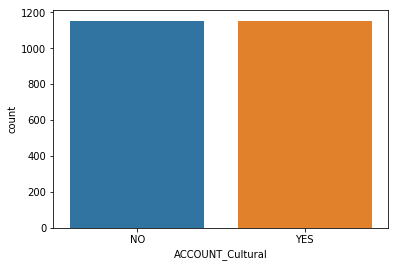

In [28]:
import seaborn as sns
sns.countplot(x = 'ACCOUNT_Cultural', data = data)

## PREPROCESS DATASET 

In [29]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [30]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [31]:
%%time
data.Excerpt = data.Excerpt.apply(lambda x: preprocess(x))

CPU times: user 613 ms, sys: 4.69 ms, total: 617 ms
Wall time: 616 ms


In [32]:
data.columns

Index(['StoryID', 'Excerpt', 'Excerpt_pre', 'Excerpt_tokenized',
       'Excerpt_nonstop', 'Excerpt_stemmed', 'Excerpt_lemmatized',
       'Excerpt_clean', 'ACCOUNT_Cultural'],
      dtype='object')

In [33]:
data.head()

,StoryID,Excerpt,Excerpt_pre,Excerpt_tokenized,Excerpt_nonstop,Excerpt_stemmed,Excerpt_lemmatized,Excerpt_clean,ACCOUNT_Cultural
4788,NI2554,postcards part one campaign launched everytown...,postcards part one campaign launched everytown...,"['postcards', 'part', 'one', 'campaign', 'laun...","['postcards', 'part', 'one', 'campaign', 'laun...","['postcard', 'part', 'one', 'campaign', 'launc...","['postcard', 'part', 'one', 'campaign', 'launc...","['postcard', 'part', 'one', 'campaign', 'launc...",NO
2318,NI1120,earlier press conference martinez shook visibl...,earlier press conference martinez shook visibl...,"['earlier', 'press', 'conference', 'martinez',...","['earlier', 'press', 'conference', 'martinez',...","['earlier', 'press', 'confer', 'martinez', 'sh...","['earlier', 'press', 'conference', 'martinez',...","['earlier', 'press', 'confer', 'martinez', 'sh...",YES
2068,NI2085,one rodgers parents called law enforcement age...,one rodgers parents called law enforcement age...,"['one', 'rodgers', 'parents', 'called', 'law',...","['one', 'rodgers', 'parents', 'called', 'law',...","['one', 'rodger', 'parent', 'call', 'law', 'en...","['one', 'rodgers', 'parent', 'called', 'law', ...","['one', 'rodger', 'parent', 'call', 'law', 'en...",YES
3683,NI2189,three victims veronika weiss 19 westlake villa...,three victims veronika weiss 19 westlake villa...,"['three', 'victims', 'veronika', 'weiss', '19'...","['three', 'victims', 'veronika', 'weiss', '19'...","['three', 'victim', 'veronika', 'weiss', '19',...","['three', 'victim', 'veronika', 'wei', '19', '...","['three', 'victim', 'veronika', 'weiss', 'west...",NO
6269,NI2618,afternoon may 23 katie called parents like eve...,afternoon may 23 katie called parents like eve...,"['afternoon', 'may', '23', 'katie', 'called', ...","['afternoon', 'may', '23', 'katie', 'called', ...","['afternoon', 'may', '23', 'kati', 'call', 'pa...","['afternoon', 'may', '23', 'katie', 'called', ...","['afternoon', 'may', 'kati', 'call', 'parent',...",NO


## SPLITTING TRAIN AND TEST 

In [34]:
df_train, df_test = train_test_split(data, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1844
TEST size: 462


## WORD2VEC 

In [35]:
%%time
documents = [_text.split() for _text in df_train.Excerpt] 

CPU times: user 5.78 ms, sys: 4.47 ms, total: 10.2 ms
Wall time: 9.96 ms


In [36]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [37]:
w2v_model.build_vocab(documents)

2019-04-06 17:27:14,345 : INFO : collecting all words and their counts
2019-04-06 17:27:14,348 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-04-06 17:27:14,369 : INFO : collected 7979 word types from a corpus of 94223 raw words and 1844 sentences
2019-04-06 17:27:14,370 : INFO : Loading a fresh vocabulary
2019-04-06 17:27:14,377 : INFO : effective_min_count=10 retains 1809 unique words (22% of original 7979, drops 6170)
2019-04-06 17:27:14,378 : INFO : effective_min_count=10 leaves 78384 word corpus (83% of original 94223, drops 15839)
2019-04-06 17:27:14,385 : INFO : deleting the raw counts dictionary of 7979 items
2019-04-06 17:27:14,386 : INFO : sample=0.001 downsamples 51 most-common words
2019-04-06 17:27:14,387 : INFO : downsampling leaves estimated 71257 word corpus (90.9% of prior 78384)
2019-04-06 17:27:14,392 : INFO : estimated required memory for 1809 words and 300 dimensions: 5246100 bytes
2019-04-06 17:27:14,393 : INFO : resetting layer we

In [38]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 1809


In [39]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2019-04-06 17:27:17,218 : INFO : training model with 8 workers on 1809 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2019-04-06 17:27:17,317 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-04-06 17:27:17,318 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-04-06 17:27:17,320 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-04-06 17:27:17,321 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-04-06 17:27:17,323 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-04-06 17:27:17,323 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-04-06 17:27:17,327 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-04-06 17:27:17,336 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-04-06 17:27:17,336 : INFO : EPOCH - 1 : training on 94223 raw words (71227 effective words) took 0.1s, 647136 effectiv

2019-04-06 17:27:18,051 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-04-06 17:27:18,053 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-04-06 17:27:18,054 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-04-06 17:27:18,056 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-04-06 17:27:18,056 : INFO : EPOCH - 10 : training on 94223 raw words (71260 effective words) took 0.1s, 975371 effective words/s
2019-04-06 17:27:18,122 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-04-06 17:27:18,124 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-04-06 17:27:18,125 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-04-06 17:27:18,126 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-04-06 17:27:18,131 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-04-06 17:27:18,132 : INFO : worker thread 

2019-04-06 17:27:18,868 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-04-06 17:27:18,875 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-04-06 17:27:18,876 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-04-06 17:27:18,879 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-04-06 17:27:18,880 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-04-06 17:27:18,882 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-04-06 17:27:18,885 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-04-06 17:27:18,888 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-04-06 17:27:18,888 : INFO : EPOCH - 20 : training on 94223 raw words (71131 effective words) took 0.1s, 907715 effective words/s
2019-04-06 17:27:18,955 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-04-06 17:27:18,961 : INFO : worker thread 

2019-04-06 17:27:19,642 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-04-06 17:27:19,643 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-04-06 17:27:19,648 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-04-06 17:27:19,649 : INFO : EPOCH - 29 : training on 94223 raw words (71272 effective words) took 0.1s, 950541 effective words/s
2019-04-06 17:27:19,715 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-04-06 17:27:19,716 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-04-06 17:27:19,717 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-04-06 17:27:19,719 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-04-06 17:27:19,720 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-04-06 17:27:19,721 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-04-06 17:27:19,726 : INFO : worker thread 

CPU times: user 12.9 s, sys: 292 ms, total: 13.2 s
Wall time: 2.67 s


(2279796, 3015136)

In [40]:
w2v_model.most_similar("gun")

/home/spriyanshu723/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2019-04-06 17:27:21,626 : INFO : precomputing L2-norms of word weight vectors


[('americans', 0.65108323097229),
 ('stricter', 0.6399435997009277),
 ('laws', 0.6221088171005249),
 ('guncontrol', 0.6190814971923828),
 ('tougher', 0.6049383878707886),
 ('wont', 0.5980437994003296),
 ('changes', 0.5875715017318726),
 ('americas', 0.5776295065879822),
 ('lobbyists', 0.5693514347076416),
 ('legislation', 0.5584716200828552)]

## TOKENIZE TEXT 

In [41]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.Excerpt)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 7980
CPU times: user 92.9 ms, sys: 3.69 ms, total: 96.6 ms
Wall time: 95.7 ms


In [42]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.Excerpt), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.Excerpt), maxlen=SEQUENCE_LENGTH)

CPU times: user 97.1 ms, sys: 0 ns, total: 97.1 ms
Wall time: 96.2 ms


In [43]:
data.head()

,StoryID,Excerpt,Excerpt_pre,Excerpt_tokenized,Excerpt_nonstop,Excerpt_stemmed,Excerpt_lemmatized,Excerpt_clean,ACCOUNT_Cultural
4788,NI2554,postcards part one campaign launched everytown...,postcards part one campaign launched everytown...,"['postcards', 'part', 'one', 'campaign', 'laun...","['postcards', 'part', 'one', 'campaign', 'laun...","['postcard', 'part', 'one', 'campaign', 'launc...","['postcard', 'part', 'one', 'campaign', 'launc...","['postcard', 'part', 'one', 'campaign', 'launc...",NO
2318,NI1120,earlier press conference martinez shook visibl...,earlier press conference martinez shook visibl...,"['earlier', 'press', 'conference', 'martinez',...","['earlier', 'press', 'conference', 'martinez',...","['earlier', 'press', 'confer', 'martinez', 'sh...","['earlier', 'press', 'conference', 'martinez',...","['earlier', 'press', 'confer', 'martinez', 'sh...",YES
2068,NI2085,one rodgers parents called law enforcement age...,one rodgers parents called law enforcement age...,"['one', 'rodgers', 'parents', 'called', 'law',...","['one', 'rodgers', 'parents', 'called', 'law',...","['one', 'rodger', 'parent', 'call', 'law', 'en...","['one', 'rodgers', 'parent', 'called', 'law', ...","['one', 'rodger', 'parent', 'call', 'law', 'en...",YES
3683,NI2189,three victims veronika weiss 19 westlake villa...,three victims veronika weiss 19 westlake villa...,"['three', 'victims', 'veronika', 'weiss', '19'...","['three', 'victims', 'veronika', 'weiss', '19'...","['three', 'victim', 'veronika', 'weiss', '19',...","['three', 'victim', 'veronika', 'wei', '19', '...","['three', 'victim', 'veronika', 'weiss', 'west...",NO
6269,NI2618,afternoon may 23 katie called parents like eve...,afternoon may 23 katie called parents like eve...,"['afternoon', 'may', '23', 'katie', 'called', ...","['afternoon', 'may', '23', 'katie', 'called', ...","['afternoon', 'may', '23', 'kati', 'call', 'pa...","['afternoon', 'may', '23', 'katie', 'called', ...","['afternoon', 'may', 'kati', 'call', 'parent',...",NO


## LABEL ENCODER 

In [44]:
labels = df_train.ACCOUNT_Cultural.unique().tolist()
labels

['YES', 'NO']

In [45]:
encoder = LabelEncoder()
encoder.fit(df_train.ACCOUNT_Cultural.tolist())

LabelEncoder()

In [46]:
y_train = encoder.transform(df_train.ACCOUNT_Cultural.tolist())
y_test = encoder.transform(df_test.ACCOUNT_Cultural.tolist())

In [47]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [48]:
print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1844, 1)
y_test (462, 1)


In [49]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1844, 300)
y_train (1844, 1)

x_test (462, 300)
y_test (462, 1)


In [50]:
y_train[:10]

array([[1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0]])

## EMBEDDING LAYER 

In [51]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(7980, 300)


In [52]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

## BUILD MODEL 

In [53]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.


2019-04-06 17:27:40,594 : WARNING : From /home/spriyanshu723/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


2019-04-06 17:27:42,062 : WARNING : From /home/spriyanshu723/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          2394000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 2,554,501
Trainable params: 160,501
Non-trainable params: 2,394,000
_________________________________________________________________


## COMPILE MODEL 

In [54]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

## CALLBACKS 

In [55]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

## TRAIN 

In [56]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.


2019-04-06 17:28:03,074 : WARNING : From /home/spriyanshu723/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Train on 1659 samples, validate on 185 samples
Epoch 1/8
1659/1659 [==============================] - 13s 8ms/step - loss: 0.6715 - acc: 0.6040 - val_loss: 0.5792 - val_acc: 0.7838
Epoch 2/8
1659/1659 [==============================] - 7s 4ms/step - loss: 0.6027 - acc: 0.7233 - val_loss: 0.5269 - val_acc: 0.7892
Epoch 3/8
1659/1659 [==============================] - 8s 5ms/step - loss: 0.5544 - acc: 0.7517 - val_loss: 0.4931 - val_acc: 0.8000
Epoch 4/8
1659/1659 [==============================] - 8s 5ms/step - loss: 0.5234 - acc: 0.7637 - val_loss: 0.4693 - val_acc: 0.8162
Epoch 5/8
1659/1659 [==============================] - 7s 4ms/step - loss: 0.4969 - acc: 0.7673 - val_loss: 0.4506 - val_acc: 0.8216
Epoch 6/8
1659/1659 [==============================] - 8s 5ms/step - loss: 0.4775 - acc: 0.7728 - val_loss: 0.4344 - val_acc: 0.8162
Epoch 7/8
1659/1659 [==============================] - 7s 5ms/step - loss: 0.4577 - acc: 0.7914 - val_loss: 0.4152 - val_acc: 0.8324
Epoch 8/8
1659/1659 [

## EVALUATE 

In [57]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

462/462 [==============================] - 1s 1ms/step

ACCURACY: 0.8138527870178223
LOSS: 0.41680651903152466
CPU times: user 3.37 s, sys: 627 ms, total: 4 s
Wall time: 693 ms


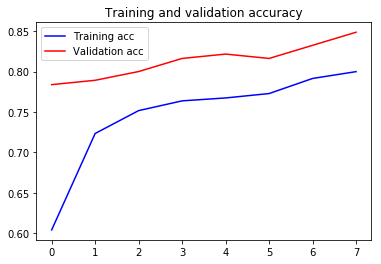

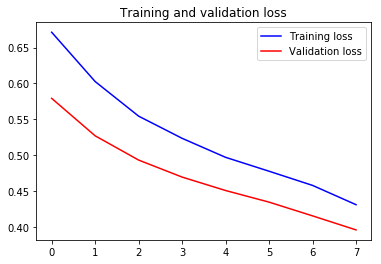

In [58]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

## PREDICT 

In [59]:
def decode_hate(score):
    if score < 0.51:
        return "YES"
    else:
        return "NO"

In [60]:
def predict(text):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_hate(score)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [61]:
predict(" Armchair psychologists have diagnosed Rodger with mistreated autism, pathological narcissism, depression, anxiety, psychosis, paranoid schizophrenia or bipolar disorder.")

{'label': 'YES',
 'score': 0.2989588677883148,
 'elapsed_time': 0.2214217185974121}

## SAVE MODEL 

In [74]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2019-04-06 15:31:30,811 : INFO : saving Word2Vec object under model_culture.w2v, separately None
2019-04-06 15:31:30,812 : INFO : not storing attribute vectors_norm
2019-04-06 15:31:30,814 : INFO : not storing attribute cum_table
2019-04-06 15:31:30,870 : INFO : saved model_culture.w2v
